In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

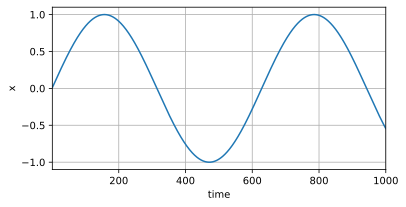

In [69]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01*time)
# x = torch.sin(0.01 * time) + torch.normal(mean=0, std=0.2, size=(T,)) # 均值为0,标准正态分布为0.2的正态分布
d2l.plot(time, [x], 'time', 'x', xlim=[1,1000], figsize=(6,3))

In [70]:
# 马尔可夫
tau = 1
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1,1))
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [71]:
x.shape

torch.Size([1000])

In [72]:
features[:n_train].shape

torch.Size([600, 1])

In [73]:
labels[:n_train].shape

torch.Size([600, 1])

In [74]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight) # xavier初始化参数

def get_net():
    net = nn.Sequential(nn.Linear(1, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [75]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch+1},'
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1,loss: 0.018778
epoch 2,loss: 0.002663
epoch 3,loss: 0.001735
epoch 4,loss: 0.001240
epoch 5,loss: 0.000997


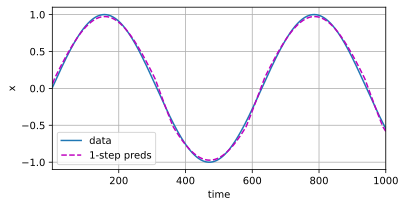

In [76]:
onestep_pred = net(features)
onestep_pred.shape
d2l.plot([time, time[tau:]],[x.detach().numpy(), onestep_pred.detach().numpy()],
         'time', 'x', legend=['data', '1-step preds'], xlim=[1,1000],
         figsize=(6,3))

In [77]:
multistep_preds = torch.zeros(T)
multistep_preds.shape

torch.Size([1000])

tensor([[-0.8274]], grad_fn=<ReshapeAliasBackward0>)


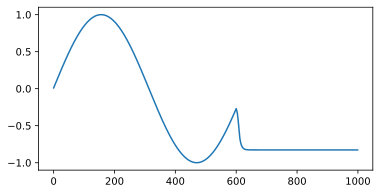

In [78]:
multistep_preds[:n_train+tau] = x[:n_train+tau]
for i in range(n_train+tau, T):
    multistep_preds[i] = net(
        multistep_preds[i-tau:i].reshape((1,-1))
    )
    if i == T-1:
        print(multistep_preds[i-tau:i].reshape((1,-1)))
d2l.plt.plot(torch.arange(T), multistep_preds.detach().numpy())

In [79]:
max_steps = 64
features = torch.zeros((T-tau-max_steps+1,tau+max_steps))
features.shape

torch.Size([936, 65])

In [82]:
for i in range(tau):
    features[:,i]=x[i:i+T-tau-max_steps+1]
for i in range(tau, tau+max_steps):
    features[:, i]=net(features[:,i-tau:i]).reshape(-1)
features.shape


torch.Size([936, 65])

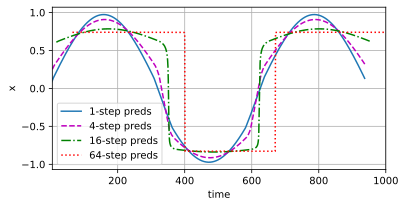

In [81]:
steps = (1,4,16,64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))